In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import math
import codecs, json 

import cv2
import matplotlib.pyplot as plt

from sklearn import mixture
from scipy import linalg as la
from scipy import stats as st
from scipy.interpolate import griddata
from scipy.interpolate import interp1d

import numpy as np
from keras.layers import *
from keras.models import Model
from keras.datasets import mnist
from keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [2]:
def read_tempdata(rn, path):
    arr = np.zeros([rn,8,8])
    with open(path) as f:
        for k in range(rn):
            for i in range(8):
                line = f.readline()
                t = [float(x) for x in line.split()]
                arr[k,i] = t
            line = f.readline()
    return arr

def read_gtempdata(rn,gpath,num):
    garr = np.zeros([num,rn,8,8])
    for n in range(num):
        path = gpath + str(n+1) +'.txt'
        garr[n] = read_tempdata(rn, path)
    return garr

In [3]:
points = [(math.floor(ix / 8), (ix % 8)) for ix in range(0, 64)]
grid_x, grid_y = np.mgrid[0:7:64j, 0:7:64j]

def show_temp(arr, mintemp = 26, maxtemp = 32):
    plt.figure(figsize=(6,5))
    bicubic = griddata(points, arr.reshape(-1), (grid_x, grid_y), method='cubic')
    pcm = plt.pcolormesh(np.flip(bicubic,0), cmap='jet', vmin = mintemp, vmax = maxtemp)
    plt.colorbar(pcm, fraction=0.175,pad=0.02)
    plt.axis('off')
    plt.show()
    
    return np.amax(bicubic)


def show_gtemp(garr,ln,weight = None, mintemp = 26, maxtemp = 32):
    fig, axs = plt.subplots(ln, ln, figsize=(15, 15))
    amax = np.zeros((ln,ln))
    for n in range(ln**2):
        col = int(n/ln)
        row = int(n%ln)
        bicubic = griddata(points, garr[n].reshape(-1), (grid_x, grid_y), method='cubic')
        if np.any(weight) != None:
            wbicubic = griddata(points, weight[n].reshape(-1)*80, (grid_x, grid_y), method='cubic')/80
            wbicubic[wbicubic < 0] = 0
            wbicubic[wbicubic > 1] = 1
            bicubic = bicubic*(1-wbicubic) + np.amin(garr)*wbicubic
        ax = axs[col,row]
        pcm = ax.pcolormesh(np.flip(bicubic,0), cmap='jet', vmin = mintemp, vmax = maxtemp)
        ax.set_axis_off()
        amax[col,row] = np.amax(bicubic)
    
    fig.colorbar(pcm, ax= axs[:], fraction=0.0175,pad=0.02)

    plt.show()
    print(amax.round(2))

In [6]:
def thermal_interpolate(garr,oy,ox,ny,nx):
    interpol = np.zeros((ny,nx,8,8))
    garr2 = garr.reshape((oy,ox,8,8))
    for i in range(ny):
        for j in range(nx):
            y2 = max(0,math.ceil(i*(oy-1)/(ny-1)))
            y1 = y2-1
            x2 = max(0,math.ceil(j*(ox-1)/(nx-1)))
            x1 = x2-1
            ly = i*(oy-1)/(ny-1) - y1
            lx = j*(ox-1)/(nx-1) - x1
            inter1 = garr2[y1,x1]*(1-ly)+garr2[y2,x1]*ly
            inter2 = garr2[y1,x2]*(1-ly)+garr2[y2,x2]*ly
            interpol[i,j] = inter1*(1-lx)+inter2*lx
    return interpol

def reg_interpolate(garr,oy,ox,ny,nx):
    interpol = np.zeros((ny,nx))
    garr2 = garr.reshape((oy,ox))
    for i in range(ny):
        for j in range(nx):
            y2 = max(0,math.ceil(i*(oy-1)/(ny-1)))
            y1 = y2-1
            x2 = max(0,math.ceil(j*(ox-1)/(nx-1)))
            x1 = x2-1
            ly = i*(oy-1)/(ny-1) - y1
            lx = j*(ox-1)/(nx-1) - x1
            inter1 = garr2[y1,x1]*(1-ly)+garr2[y2,x1]*ly
            inter2 = garr2[y1,x2]*(1-ly)+garr2[y2,x2]*ly
            interpol[i,j] = inter1*(1-lx)+inter2*lx
    return interpol

def output_interpolate(temp_path, ln2, dis):
    interpol = np.zeros((4,ln2**2,100,8,8))
    ln = 6
    bg_max = 0
    for i in range(4):
        datapath = 'train/' + temp_path + '/output-' + str(i+1)+ '/'

        garr = read_gtempdata(100,datapath,ln**2)

        interpol[i] = thermal_interpolate(garr,ln**2,100,ln2**2,100)
        ln -= 1
    interpol = thermal_interpolate(interpol,4,(ln2**2)*100,dis,(ln2**2)*100)
    return interpol


def load_temperature():
    ln = 6
    dis = 16
    x_train = np.zeros((4,dis,ln**2,100,8,8))
    temp_path = np.array(['hot','warm','semicold','cold'])
    for i in range(4):
        x_train[i] = output_interpolate(temp_path[i],ln,dis).reshape(dis,ln**2,100,8,8)
    x_train = thermal_interpolate(x_train,4,(ln**2)*100*dis,16,(ln**2)*100*dis)
    x_train = x_train.reshape(-1,8,8,1) 
    
    
    file_path = "amax.json"
    obj_text = codecs.open(file_path, 'r', encoding='utf-8').read()
    arr_list= json.loads(obj_text)
    arr_ans = reg_interpolate(np.array(arr_list),4,4*(ln**2),16,4*(ln**2))
    arr_ans = reg_interpolate(arr_ans.transpose(1,0),4,16*(ln**2),dis,16*(ln**2)).reshape(dis,16,ln**2).transpose(1,0,2)
    print(np.mean(arr_ans))
    print(np.amax(arr_ans))
    print(np.amin(arr_ans))
    temp_arr = np.array([27.44472821, 26.27245937, 21.30507148, 18.32839891])
    temp_inter = np.zeros(16)
    for i in range(3):
        temp_inter[i*5:(i+1)*5+1] = np.linspace(temp_arr[i],temp_arr[i+1],6)
        
    y_train = np.ones((5,16,dis,ln**2,100))
    y_train[0] = ((np.ones((100,16,dis,ln**2))*arr_ans).transpose(1,2,3,0)-29)/6
    y_train[1] = (np.ones((dis,ln**2,100,16))*temp_inter).transpose(3,0,1,2)/25 -1
    y_train[2] = (np.ones((16,ln**2,100,dis))*np.linspace(0.25,1.75,dis)).transpose(0,3,1,2)-1
    pos_x = np.array([np.arange(1/6,2,1/3),]*6)-1
    pos_y = pos_x.T
    y_train[3] = (np.ones((16,dis,100,ln**2))*pos_x.reshape(-1)).transpose(0,1,3,2)
    y_train[4] = (np.ones((16,dis,100,ln**2))*pos_y.reshape(-1)).transpose(0,1,3,2)
    y_train = y_train.reshape(5,-1).T
    
    indices = np.arange(x_train.shape[0])
    np.random.shuffle(indices)
    
    ind = math.floor(x_train.shape[0]*0.2)
    ind_half = math.floor(ind*0.5)
    return x_train[indices[:-ind]], y_train[indices[:-ind]], x_train[indices[-ind:-ind_half]], y_train[indices[-ind:-ind_half]], x_train[indices[-ind_half:]], y_train[indices[-ind_half:]]

In [7]:
x_train, y_train, x_test, y_test, x_val, y_val = load_temperature()

x_train.shape[0]

29.698043749419394
32.22236585365853
25.355951393356776


737280

In [8]:
input_shape = (8,8,1)
kernel_size = 3
filters = 64
dropout = 0.3

# use functional API to build cnn layers
inputs = Input(shape=input_shape)
# y = Dropout(0.2)(inputs)
y = Conv2D(filters=filters,
           kernel_size=kernel_size,
           padding='same',
           activation='relu')(inputs)
y = Conv2D(filters=filters*2,
           kernel_size=kernel_size,
           activation='relu')(y)
y = MaxPooling2D()(y)

y = Conv2D(filters=filters*2,
           kernel_size=kernel_size,
           padding='same',
           activation='relu')(y)
y = Conv2D(filters=filters*4,
           kernel_size=kernel_size,
           activation='relu')(y)
# y = Dropout(dropout)(y)

# image to vector before connecting to dense layer
y = Flatten()(y)
y = Dense(filters*8, activation='relu')(y)
y = Dense(filters*8, activation='relu')(y)
# dropout regularization
# y = Dropout(dropout)(y)
outputs = Dense(5, activation='tanh')(y)

# build the model by supplying inputs/outputs
model = Model(inputs=inputs, outputs=outputs)
# network model in text
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8, 8, 1)]         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 8, 8, 64)          640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 128)         73856     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 3, 3, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 128)         147584    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 1, 256)         295168    
_________________________________________________________________
flatten (Flatten)            (None, 256)              

In [9]:
opt = Adam(lr=0.0002, beta_1=0.5)
model.compile(loss='mse',
              optimizer= opt,
              metrics=['accuracy'])

batch_size = 256
history = model.fit(x_train,
          y_train,
          validation_data=(x_test, y_test),
          epochs=200,
          batch_size=batch_size)

score = model.evaluate(x_test, y_test, batch_size=batch_size)
print("\nTest accuracy: %.1f%%" % (100.0 * score[1]))

Epoch 1/200
2880/2880 [==============================] - 10s 3ms/step - loss: 0.0501 - accuracy: 0.6896 - val_loss: 0.0221 - val_accuracy: 0.7817
Epoch 2/200
2880/2880 [==============================] - 9s 3ms/step - loss: 0.0172 - accuracy: 0.8057 - val_loss: 0.0147 - val_accuracy: 0.7985
Epoch 3/200
2880/2880 [==============================] - 9s 3ms/step - loss: 0.0121 - accuracy: 0.8338 - val_loss: 0.0113 - val_accuracy: 0.8478
Epoch 4/200
2880/2880 [==============================] - 9s 3ms/step - loss: 0.0088 - accuracy: 0.8598 - val_loss: 0.0093 - val_accuracy: 0.8637
Epoch 5/200
2880/2880 [==============================] - 9s 3ms/step - loss: 0.0066 - accuracy: 0.8811 - val_loss: 0.0071 - val_accuracy: 0.8735
Epoch 6/200
2880/2880 [==============================] - 9s 3ms/step - loss: 0.0052 - accuracy: 0.8955 - val_loss: 0.0040 - val_accuracy: 0.9014
Epoch 7/200
2880/2880 [==============================] - 9s 3ms/step - loss: 0.0045 - accuracy: 0.9027 - val_loss: 0.0038 - val_a

2880/2880 [==============================] - 9s 3ms/step - loss: 3.7829e-04 - accuracy: 0.9567 - val_loss: 4.6657e-04 - val_accuracy: 0.9498
Epoch 110/200
2880/2880 [==============================] - 9s 3ms/step - loss: 3.4302e-04 - accuracy: 0.9573 - val_loss: 4.5603e-04 - val_accuracy: 0.9486
Epoch 111/200
2880/2880 [==============================] - 9s 3ms/step - loss: 2.8640e-04 - accuracy: 0.9576 - val_loss: 2.8912e-04 - val_accuracy: 0.9619
Epoch 112/200
2880/2880 [==============================] - 9s 3ms/step - loss: 3.1249e-04 - accuracy: 0.9575 - val_loss: 5.1600e-04 - val_accuracy: 0.9511
Epoch 113/200
2880/2880 [==============================] - 9s 3ms/step - loss: 3.3079e-04 - accuracy: 0.9575 - val_loss: 3.6484e-04 - val_accuracy: 0.9422
Epoch 114/200
2880/2880 [==============================] - 9s 3ms/step - loss: 3.8388e-04 - accuracy: 0.9569 - val_loss: 4.0548e-04 - val_accuracy: 0.9499
Epoch 115/200
2880/2880 [==============================] - 9s 3ms/step - loss: 3.306

Epoch 162/200
2880/2880 [==============================] - 9s 3ms/step - loss: 3.3730e-04 - accuracy: 0.9579 - val_loss: 2.5457e-04 - val_accuracy: 0.9540
Epoch 163/200
2880/2880 [==============================] - 9s 3ms/step - loss: 1.7323e-04 - accuracy: 0.9607 - val_loss: 2.0217e-04 - val_accuracy: 0.9737
Epoch 164/200
2880/2880 [==============================] - 9s 3ms/step - loss: 3.1320e-04 - accuracy: 0.9585 - val_loss: 4.4954e-04 - val_accuracy: 0.9504
Epoch 165/200
2880/2880 [==============================] - 9s 3ms/step - loss: 2.1124e-04 - accuracy: 0.9604 - val_loss: 2.5591e-04 - val_accuracy: 0.9451
Epoch 166/200
2880/2880 [==============================] - 9s 3ms/step - loss: 3.0930e-04 - accuracy: 0.9589 - val_loss: 2.3424e-04 - val_accuracy: 0.9644
Epoch 167/200
2880/2880 [==============================] - 9s 3ms/step - loss: 2.1147e-04 - accuracy: 0.9601 - val_loss: 2.4304e-04 - val_accuracy: 0.9625
Epoch 168/200
2880/2880 [==============================] - 9s 3ms/step

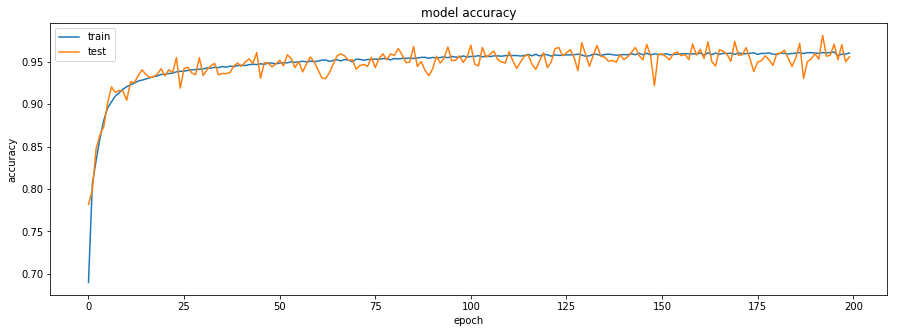

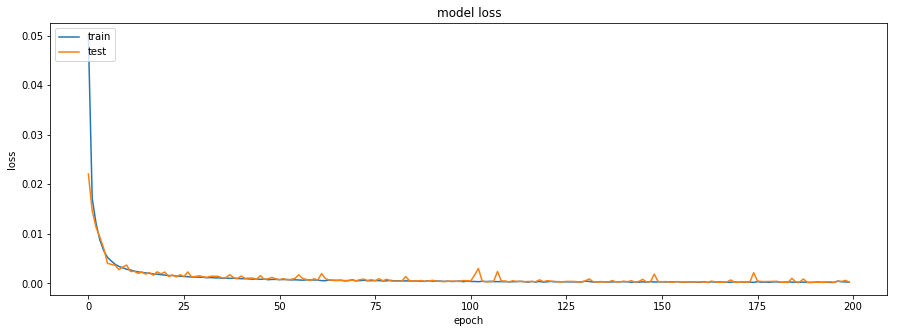

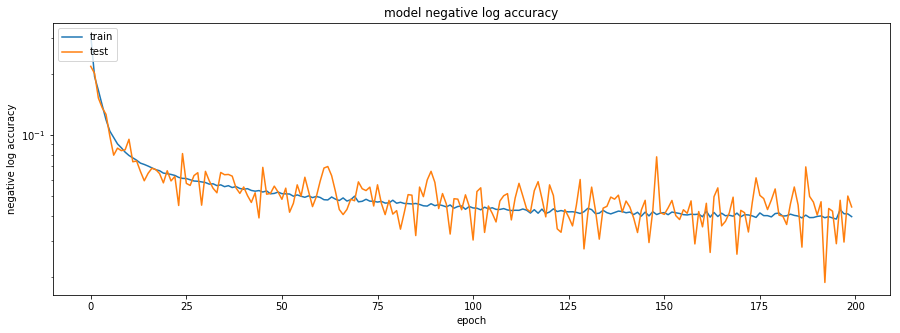

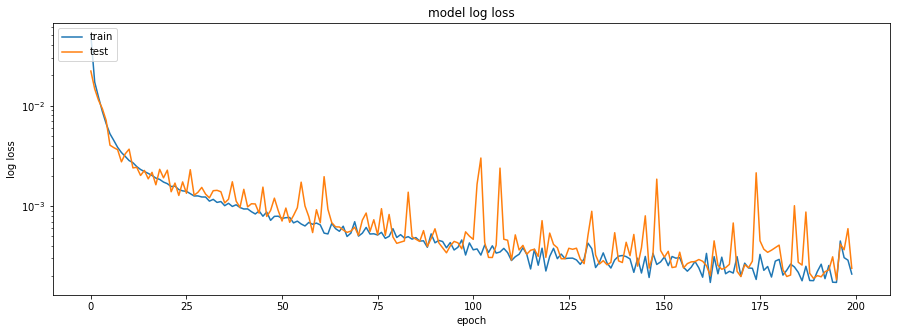

In [10]:
# summarize history for accuracy
plt.figure(figsize=(15, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.figure(figsize=(15, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#log

# summarize history for accuracy
plt.figure(figsize=(15, 5))
plt.plot(1-np.array(history.history['accuracy']))
plt.plot(1-np.array(history.history['val_accuracy']))
plt.title('model negative log accuracy')
plt.ylabel('negative log accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.yscale('log')
plt.show()
# summarize history for log loss
plt.figure(figsize=(15, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model log loss')
plt.ylabel('log loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.yscale('log')
plt.show()

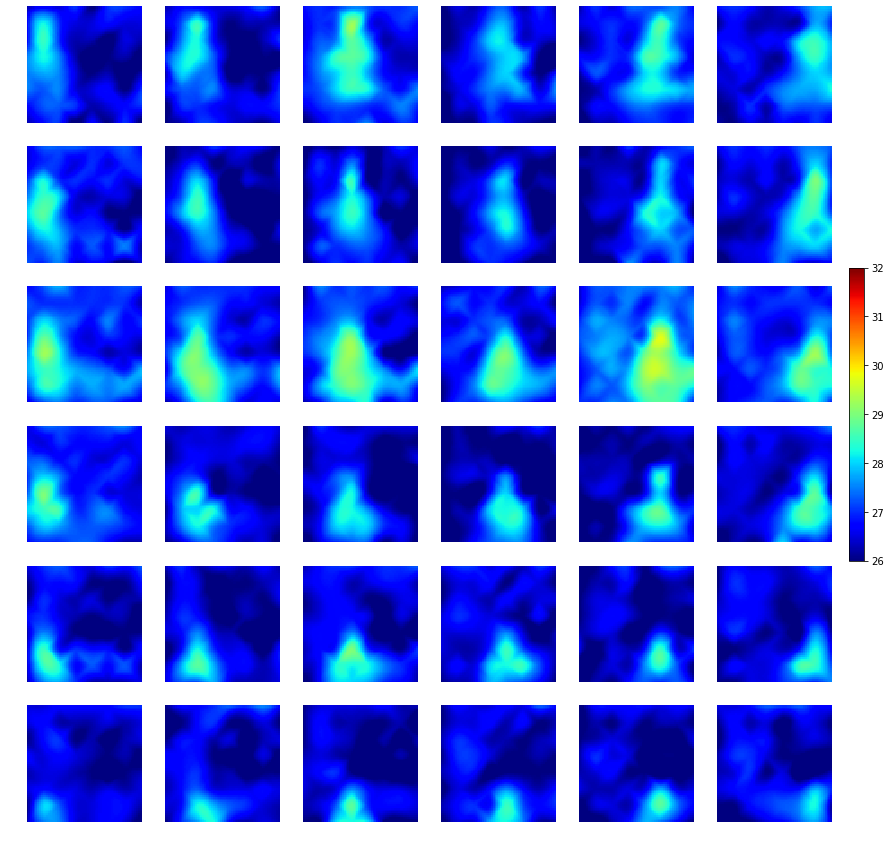

[[28.52 28.56 29.29 28.2  28.78 28.59]
 [28.75 28.58 28.56 28.39 28.43 29.  ]
 [29.27 29.15 29.3  29.07 29.79 29.26]
 [29.05 28.64 28.38 28.51 28.87 28.81]
 [28.74 28.76 29.05 28.54 28.74 28.7 ]
 [28.07 28.44 28.76 28.54 28.77 28.27]]


In [11]:
datapath = 'train/warm/output-1/'
garr = read_gtempdata(100,datapath,36)

show_gtemp(garr[:,0],6)

In [12]:
(model.predict(garr[18,0].reshape(1,8,8,1))*np.array([6,25,2,3,3])+np.array([27,25,2.5,3.5,3.5])).round(2)

array([[28.03, 26.3 ,  1.08,  0.99,  4.02]])

In [13]:
garr.shape

(36, 100, 8, 8)

In [14]:
(y_test[:100]*np.array([6,25,2,3.6,3])+np.array([27,25,2.5,3.5,3.5])).round(2)

array([[27.02, 26.74,  2.4 ,  6.5 ,  5.  ],
       [25.65, 21.31,  2.  ,  2.9 ,  4.  ],
       [28.37, 23.29,  4.  ,  2.9 ,  2.  ],
       [29.07, 26.98,  2.8 ,  2.9 ,  5.  ],
       [25.53, 22.3 ,  2.  ,  1.7 ,  2.  ],
       [26.91, 20.71,  3.2 ,  1.7 ,  6.  ],
       [28.52, 18.92,  3.4 ,  1.7 ,  6.  ],
       [28.75, 26.98,  1.8 ,  4.1 ,  5.  ],
       [27.47, 19.52,  3.  ,  0.5 ,  2.  ],
       [26.04, 25.28,  2.6 ,  6.5 ,  1.  ],
       [27.91, 25.28,  1.4 ,  0.5 ,  6.  ],
       [26.16, 22.3 ,  4.  ,  4.1 ,  5.  ],
       [27.23, 20.71,  3.6 ,  2.9 ,  3.  ],
       [26.53, 18.92,  2.2 ,  1.7 ,  1.  ],
       [28.03, 26.27,  1.8 ,  2.9 ,  1.  ],
       [27.1 , 27.21,  3.  ,  2.9 ,  2.  ],
       [25.5 , 26.27,  1.  ,  2.9 ,  2.  ],
       [29.44, 18.33,  4.  ,  1.7 ,  2.  ],
       [29.95, 25.28,  4.  ,  0.5 ,  5.  ],
       [28.6 , 26.51,  3.  ,  4.1 ,  4.  ],
       [28.39, 26.98,  3.6 ,  0.5 ,  4.  ],
       [26.87, 26.27,  2.  ,  6.5 ,  4.  ],
       [29.5 , 26.98,  2.6 ,  0.

In [15]:
(model.predict(x_test.reshape(-1,8,8,1))*np.array([6,25,2,3,3])+np.array([27,25,2.5,3.5,3.5]))[:100].round(2)

array([[27.06, 26.68,  2.44,  6.  ,  5.01],
       [25.62, 21.45,  1.96,  3.02,  3.98],
       [28.44, 23.31,  4.01,  3.  ,  2.  ],
       [29.11, 27.01,  2.81,  2.99,  4.99],
       [25.79, 22.31,  1.92,  2.  ,  1.99],
       [26.97, 20.7 ,  3.22,  2.01,  6.  ],
       [28.56, 19.06,  3.41,  1.99,  5.99],
       [28.65, 27.  ,  1.78,  4.03,  5.02],
       [27.55, 19.51,  3.  ,  1.  ,  1.99],
       [26.02, 25.27,  2.65,  5.98,  1.  ],
       [27.89, 25.39,  1.44,  0.97,  6.  ],
       [26.44, 22.17,  3.99,  3.64,  5.01],
       [27.27, 20.74,  3.61,  2.98,  3.01],
       [26.68, 19.02,  2.22,  2.03,  1.  ],
       [28.03, 26.29,  1.82,  3.  ,  1.  ],
       [27.39, 27.32,  2.96,  2.96,  2.  ],
       [25.56, 26.36,  0.95,  3.02,  1.98],
       [29.43, 18.29,  4.02,  1.99,  1.98],
       [30.02, 25.32,  4.01,  0.99,  5.  ],
       [28.71, 26.23,  2.99,  3.99,  4.  ],
       [28.43, 27.07,  3.62,  0.97,  4.01],
       [26.96, 26.22,  2.08,  6.01,  4.01],
       [29.63, 26.98,  2.63,  0.

In [16]:
abs((model.predict(x_test.reshape(-1,8,8,1))*np.array([6,25,2,3,3])+np.array([27,25,2.5,3.5,3.5])).round(2)-(y_test*np.array([6,25,2,3,3])+np.array([27,25,2.5,3.33,3.33])).round(2))[:100]

array([[0.04, 0.06, 0.04, 0.17, 0.18],
       [0.03, 0.14, 0.04, 0.19, 0.15],
       [0.07, 0.02, 0.01, 0.17, 0.17],
       [0.04, 0.03, 0.01, 0.16, 0.16],
       [0.26, 0.01, 0.08, 0.17, 0.16],
       [0.06, 0.01, 0.02, 0.18, 0.17],
       [0.04, 0.14, 0.01, 0.16, 0.16],
       [0.1 , 0.02, 0.02, 0.2 , 0.19],
       [0.08, 0.01, 0.  , 0.17, 0.16],
       [0.02, 0.01, 0.05, 0.15, 0.17],
       [0.02, 0.11, 0.04, 0.14, 0.17],
       [0.28, 0.13, 0.01, 0.19, 0.18],
       [0.04, 0.03, 0.01, 0.15, 0.18],
       [0.15, 0.1 , 0.02, 0.2 , 0.17],
       [0.  , 0.02, 0.02, 0.17, 0.17],
       [0.29, 0.11, 0.04, 0.13, 0.17],
       [0.06, 0.09, 0.05, 0.19, 0.15],
       [0.01, 0.04, 0.02, 0.16, 0.15],
       [0.07, 0.04, 0.01, 0.16, 0.17],
       [0.11, 0.28, 0.01, 0.16, 0.17],
       [0.04, 0.09, 0.02, 0.14, 0.18],
       [0.09, 0.05, 0.08, 0.18, 0.18],
       [0.13, 0.  , 0.03, 0.16, 0.16],
       [0.04, 0.02, 0.02, 0.16, 0.18],
       [0.04, 0.04, 0.02, 0.17, 0.16],
       [0.07, 0.01, 0.01,

In [17]:
np.mean(abs((model.predict(x_test.reshape(-1,8,8,1))*np.array([6,25,2,3,3])+np.array([27,25,2.5,3.5,3.5])).round(2)-(y_test*np.array([6,25,2,3,3])+np.array([27,25,2.5,3.33,3.33]))), axis = 0).round(2)

array([0.08, 0.07, 0.03, 0.17, 0.17])

In [18]:
np.amax(abs((model.predict(x_test.reshape(-1,8,8,1))*np.array([6,25,2,3,3])+np.array([27,25,2.5,3.5,3.5])).round(2)-(y_test*np.array([6,25,2,3,3])+np.array([27,25,2.5,3.33,3.33]))), axis = 0).round(2)

array([4.6 , 1.24, 0.49, 5.09, 1.09])

In [19]:
np.median(abs((model.predict(x_test.reshape(-1,8,8,1))*np.array([6,25,2,3,3])+np.array([27,25,2.5,3.5,3.5])).round(2)-(y_test*np.array([6,25,2,3,3])+np.array([27,25,2.5,3.33,3.33]))), axis = 0).round(2)

array([0.05, 0.05, 0.02, 0.17, 0.17])

In [20]:
np.median(abs((model.predict(x_val.reshape(-1,8,8,1))*np.array([6,25,2,3,3])+np.array([27,25,2.5,3.5,3.5])).round(2)-(y_val*np.array([6,25,2,3,3])+np.array([27,25,2.5,3.33,3.33]))), axis = 0).round(2)

array([0.05, 0.05, 0.02, 0.17, 0.17])

In [21]:
(model.predict(x_val.reshape(-1,8,8,1))*np.array([6,25,2,3,3])+np.array([27,25,2.5,3.5,3.5]))[:100].round(2)

array([[27.88, 19.57,  1.61,  2.99,  1.  ],
       [29.17, 20.78,  2.25,  5.02,  4.  ],
       [28.95, 26.29,  2.48,  4.01,  3.01],
       [29.64, 26.71,  3.22,  5.  ,  1.01],
       [29.2 , 26.75,  3.99,  1.  ,  5.  ],
       [29.62, 27.38,  3.84,  3.21,  1.  ],
       [27.27, 26.92,  1.56,  2.99,  6.  ],
       [27.  , 26.59,  3.2 ,  4.  ,  5.01],
       [26.38, 18.76,  2.22,  3.98,  6.  ],
       [28.58, 27.49,  3.57,  4.  ,  2.  ],
       [26.6 , 26.61,  2.54,  1.  ,  1.  ],
       [29.06, 26.31,  1.75,  1.02,  5.99],
       [30.12, 21.44,  1.99,  1.01,  5.  ],
       [26.37, 26.44,  1.4 ,  5.03,  2.02],
       [29.57, 18.81,  3.8 ,  2.97,  5.01],
       [27.47, 26.23,  1.38,  3.  ,  3.97],
       [27.4 , 22.26,  1.6 ,  1.98,  4.  ],
       [26.87, 18.3 ,  2.17,  6.01,  5.02],
       [27.52, 19.62,  1.83,  5.  ,  6.  ],
       [28.36, 20.54,  3.63,  2.98,  5.01],
       [26.26, 21.32,  1.03,  4.03,  6.01],
       [30.09, 27.49,  4.  ,  2.99,  6.  ],
       [29.29, 27.26,  3.44,  2.